# Test of ESIS Reproducibility
_Roy Smart and Charles Kankelborg_

Set up environment and import required packages.

In [1]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import warnings
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
import pandas as pd
import kgpy.optics
import kgpy.vector
import esis.optics

warnings.filterwarnings('ignore')

In [2]:
pupil_samples = 100
pupil_samples_small = 9
field_samples = 7
esis_optics_small = esis.optics.design.final(pupil_samples=pupil_samples_small, field_samples=field_samples)
esis_optics = esis.optics.design.final(pupil_samples=pupil_samples, field_samples=field_samples)

In [3]:
new_esis_optics = esis.optics.design.final_from_poletto(
    pupil_samples=pupil_samples, 
    field_samples=field_samples,
    use_toroidal_grating=False,
    use_vls_grating=True,
    use_one_wavelength_detector_tilt=True,
)
new_esis_optics_small = new_esis_optics.copy()
new_esis_optics_small.pupil_samples = esis_optics_small.pupil_samples
new_esis_optics_small.field_samples = esis_optics_small.field_samples
new_esis_optics_small.update()

In [4]:
name_old = 'Final'
name_new = 'Reconstructed'
names = [name_old, name_new]

## Layout

<IPython.core.display.Javascript object>


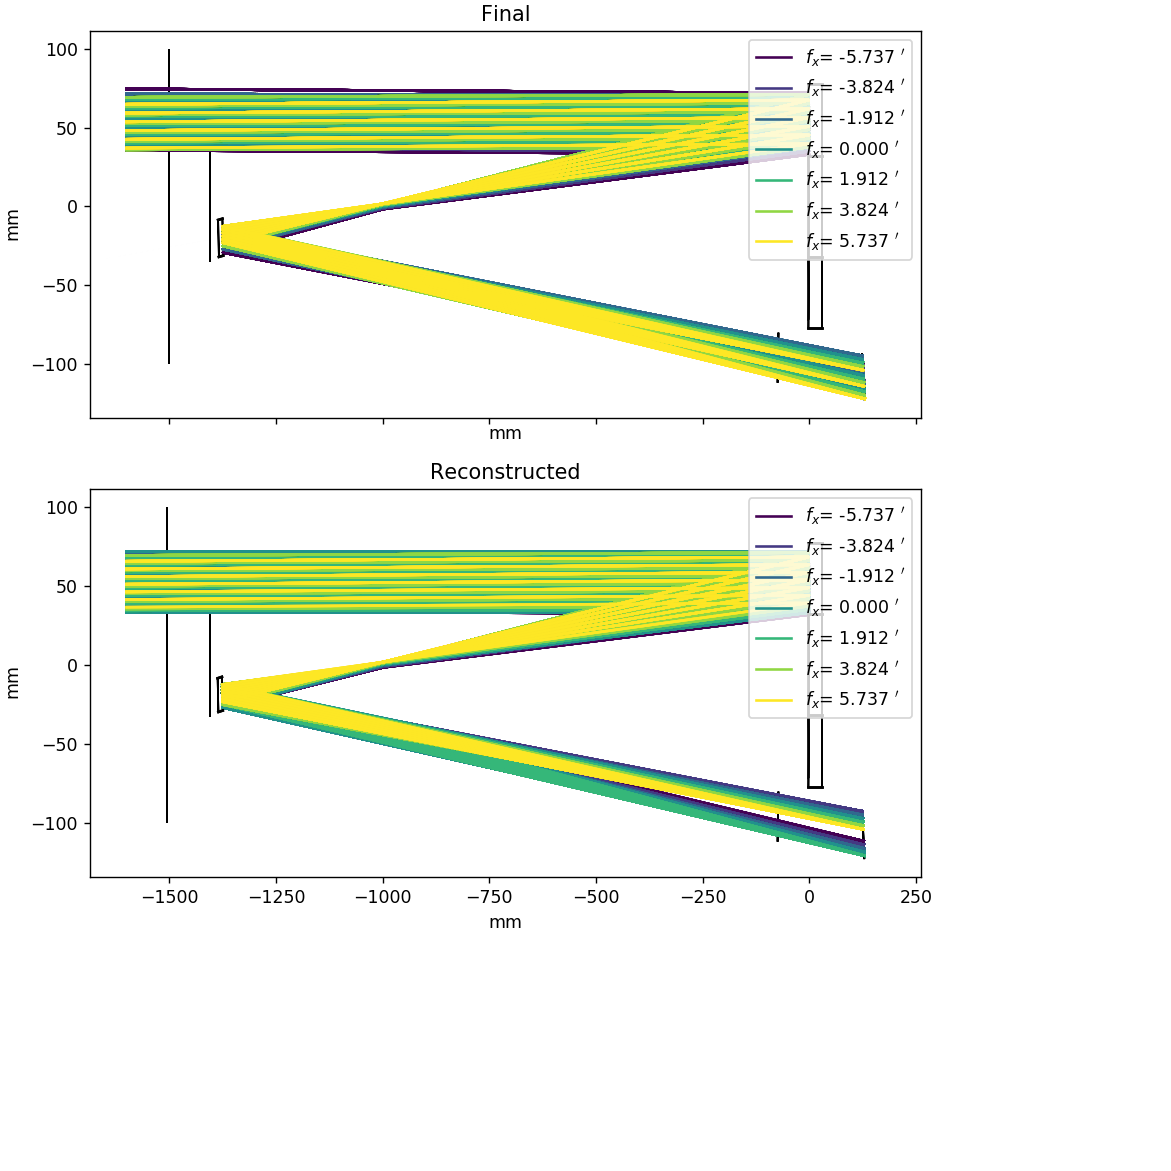

In [5]:
color_axis = kgpy.optics.Rays.axis.field_x
fig_layout, axs_layout = plt.subplots(
    nrows=2, 
    figsize=(7.5, 7.5), 
    constrained_layout=True,
    sharex=True,
    sharey=True,
)
_ = esis_optics_small.system.plot(
    ax=axs_layout[0],
    components=(kgpy.vector.iz, kgpy.vector.ix),
    color_axis=color_axis,
)
_ = new_esis_optics_small.system.plot(
    ax=axs_layout[1],
    components=(kgpy.vector.iz, kgpy.vector.ix),
    color_axis=color_axis,
)
_ = axs_layout[0].set_title(name_old)
_ = axs_layout[1].set_title(name_new)
# _ = axs_layout[0].axis('equal')
# _ = axs_layout[1].axis('equal')

<IPython.core.display.Javascript object>


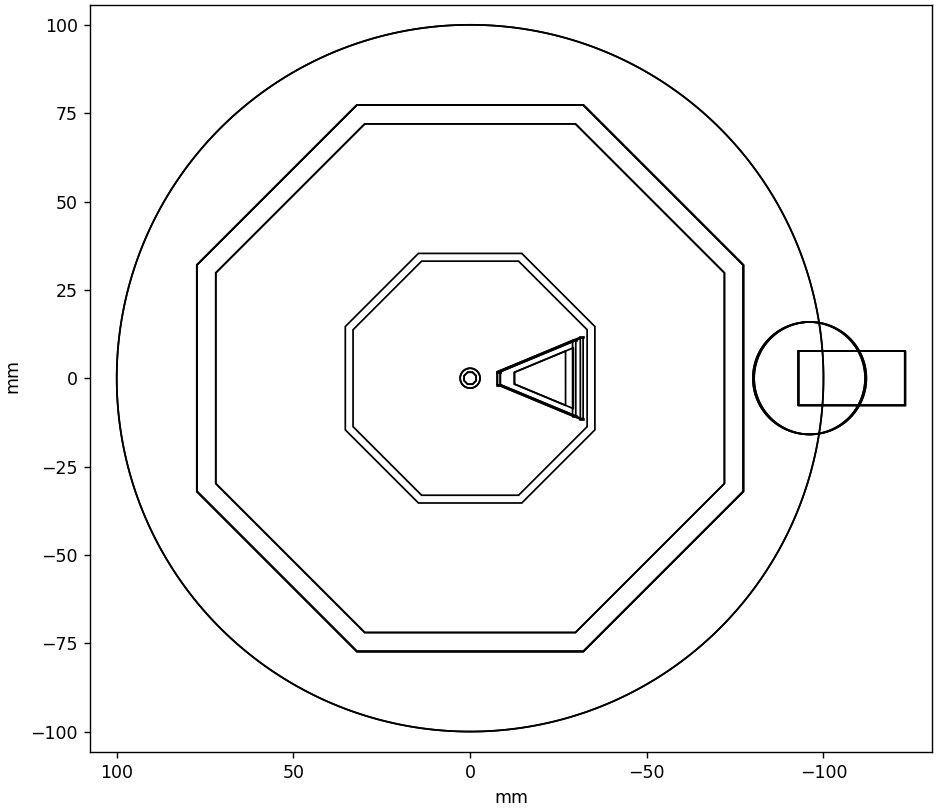

In [6]:
fig_bore, ax_bore = plt.subplots(
    figsize=(7.5, 6.5), 
    constrained_layout=True,
)
ax_bore.invert_xaxis()
_ = esis_optics_small.system.plot(
    ax=ax_bore,
    plot_rays=False,
)
_ = new_esis_optics_small.system.plot(
    ax=ax_bore,
    plot_rays=False,
)
_ = ax_bore.axis('equal')

In [7]:
c_old = esis_optics.components
c_new = new_esis_optics.components

In [8]:
table_source = pd.concat([c_old.source.dataframe, c_new.source.dataframe])
table_source.index = names
table_source.T

,Final,Reconstructed
name,sun,sun
piston,1600.000 $\mathrm{mm}$,1600.000 $\mathrm{mm}$
half width,5.737 $\mathrm{{}^{\prime}}$,5.737 $\mathrm{{}^{\prime}}$
half height,5.737 $\mathrm{{}^{\prime}}$,5.737 $\mathrm{{}^{\prime}}$


## Front Aperture Plate

In [9]:
table_front_aper = pd.concat([c_old.front_aperture.dataframe, c_new.front_aperture.dataframe])
table_front_aper.index = names
table_front_aper.T

,Final,Reconstructed
name,front aperture,front aperture
piston,1500.000 $\mathrm{mm}$,1505.396 $\mathrm{mm}$
clear radius,100.000 $\mathrm{mm}$,100.000 $\mathrm{mm}$


<IPython.core.display.Javascript object>


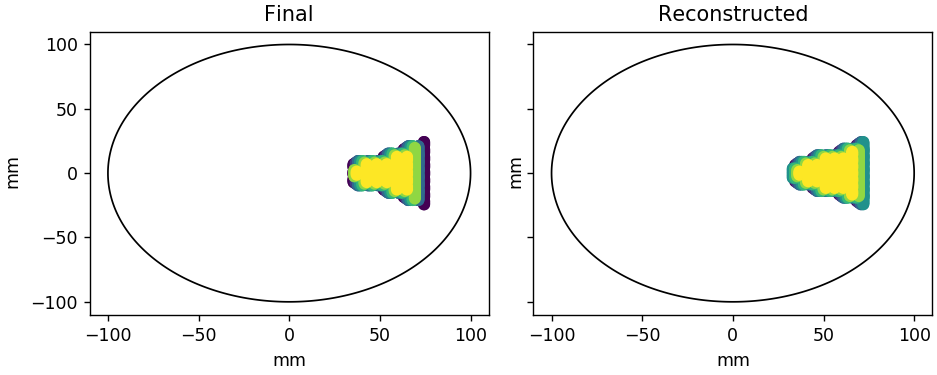

In [10]:
fig_front_aper, axs_front_aper = plt.subplots(
    ncols=2, 
    figsize=(7.5, 3), 
    constrained_layout=True,
    sharex=True,
    sharey=True,
)
_ = esis_optics_small.system.plot_footprint(
    ax=axs_front_aper[0],
    surf=esis_optics_small.components.front_aperture.surface,
    color_axis=color_axis,
)
_ = new_esis_optics_small.system.plot_footprint(
    ax=axs_front_aper[1],
    surf=new_esis_optics_small.components.front_aperture.surface,
    color_axis=color_axis,
)
axs_front_aper[0].get_legend().remove()
axs_front_aper[1].get_legend().remove()
_ = axs_front_aper[0].set_title(name_old)
_ = axs_front_aper[1].set_title(name_new)

## Central Obscuration

In [11]:
table_obs = pd.concat([c_old.central_obscuration.dataframe, c_new.central_obscuration.dataframe])
table_obs.index = names
table_obs

,name,piston,obscured half-width,number of sides
Final,obscuration,1404.270 $\mathrm{mm}$,35.313 $\mathrm{mm}$,8
Reconstructed,obscuration,1405.396 $\mathrm{mm}$,33.122 $\mathrm{mm}$,8


<IPython.core.display.Javascript object>


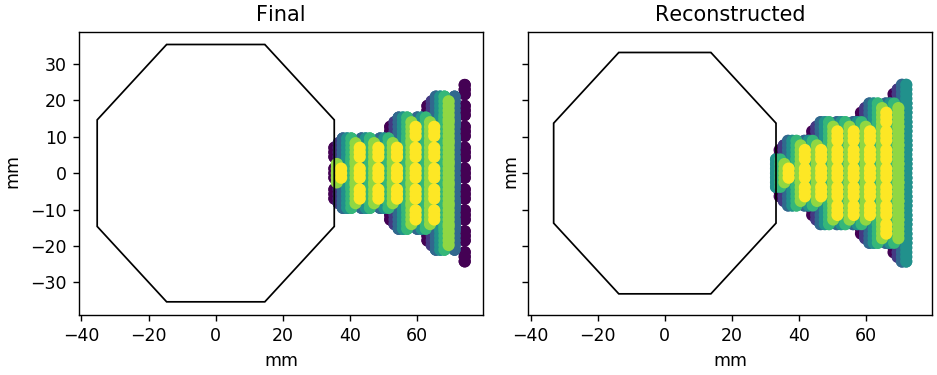

In [12]:
fig_obscuration, axs_obscuration = plt.subplots(
    ncols=2, 
    figsize=(7.5, 3), 
    constrained_layout=True,
    sharex=True,
    sharey=True,
)
_ = esis_optics_small.system.plot_footprint(
    ax=axs_obscuration[0],
    surf=esis_optics.components.central_obscuration.surface,
    color_axis=color_axis,
)
_ = new_esis_optics_small.system.plot_footprint(
    ax=axs_obscuration[1],
    surf=new_esis_optics.components.central_obscuration.surface,
    color_axis=color_axis,
)
axs_obscuration[0].get_legend().remove()
axs_obscuration[1].get_legend().remove()
_ = axs_obscuration[0].set_title(name_old)
_ = axs_obscuration[1].set_title(name_new)

## Primary Mirror

In [13]:
table_primary = pd.concat([c_old.primary.dataframe, c_new.primary.dataframe])
table_primary.index = names
table_primary

,name,piston,radius,conic constant,number of sides,clear half-width,border width,substrate thickness
Final,primary,0.000 $\mathrm{mm}$,2000.000 $\mathrm{mm}$,-1.000 $\mathrm{}$,8,71.970 $\mathrm{mm}$,5.359 $\mathrm{mm}$,30.000 $\mathrm{mm}$
Reconstructed,primary,0.000 $\mathrm{mm}$,2000.000 $\mathrm{mm}$,-1.000 $\mathrm{}$,8,71.970 $\mathrm{mm}$,5.359 $\mathrm{mm}$,30.000 $\mathrm{mm}$


<IPython.core.display.Javascript object>


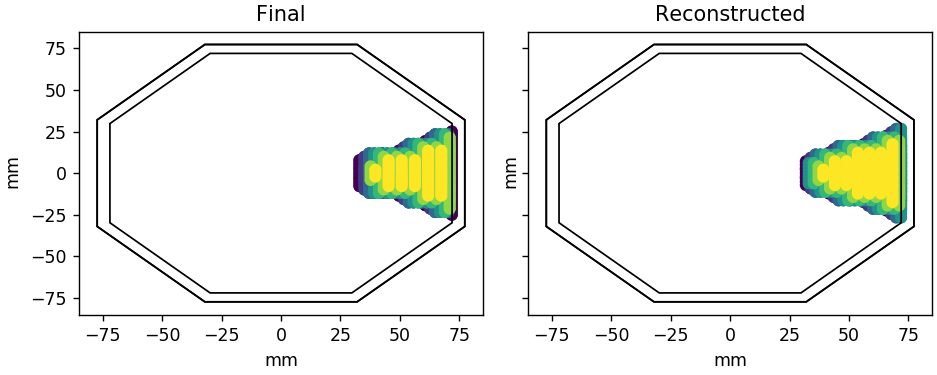

In [14]:
fig_primary, axs_primary = plt.subplots(
    ncols=2, 
    figsize=(7.5, 3), 
    constrained_layout=True,
    sharex=True,
    sharey=True,
)
_ = esis_optics_small.system.plot_footprint(
    ax=axs_primary[0],
    surf=esis_optics.components.primary.surface,
    color_axis=color_axis,
)
_ = new_esis_optics_small.system.plot_footprint(
    ax=axs_primary[1],
    surf=new_esis_optics.components.primary.surface,
    color_axis=color_axis,
)
axs_primary[0].get_legend().remove()
axs_primary[1].get_legend().remove()
_ = axs_primary[0].set_title(name_old)
_ = axs_primary[1].set_title(name_new)

## Field Stop

In [15]:
table_fs = pd.concat([c_old.field_stop.dataframe, c_new.field_stop.dataframe])
table_fs.index = names
table_fs

,name,piston,clear radius,mechanical radius,number of sides
Final,field stop,1000.000 $\mathrm{mm}$,1.820 $\mathrm{mm}$,2.810 $\mathrm{mm}$,8
Reconstructed,field stop,1000.000 $\mathrm{mm}$,1.839 $\mathrm{mm}$,2.810 $\mathrm{mm}$,8


<IPython.core.display.Javascript object>


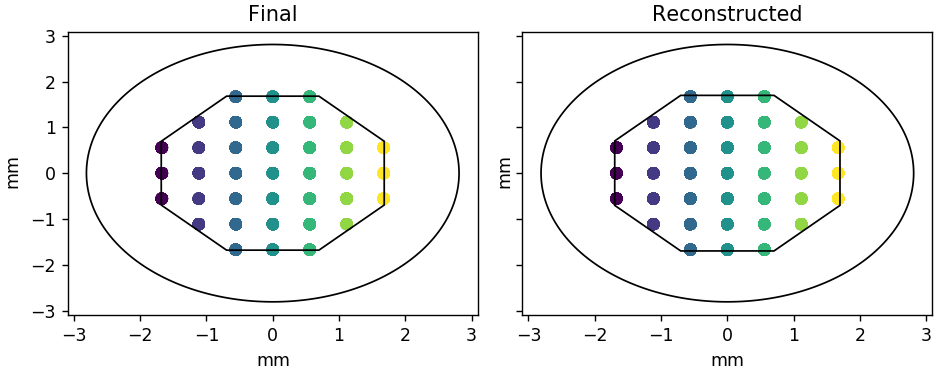

In [16]:
fig_field_stop, axs_field_stop = plt.subplots(
    ncols=2, 
    figsize=(7.5, 3), 
    constrained_layout=True,
    sharex=True,
    sharey=True,
)
_ = esis_optics_small.system.plot_footprint(
    ax=axs_field_stop[0],
    surf=esis_optics.components.field_stop.surface,
    color_axis=color_axis,
)
_ = new_esis_optics_small.system.plot_footprint(
    ax=axs_field_stop[1],
    surf=new_esis_optics.components.field_stop.surface,
    color_axis=color_axis,

)
axs_field_stop[0].get_legend().remove()
axs_field_stop[1].get_legend().remove()
_ = axs_field_stop[0].set_title(name_old)
_ = axs_field_stop[1].set_title(name_new)

## Grating

In [17]:
table_grating = pd.concat([c_old.grating.dataframe, c_new.grating.dataframe])
table_grating.index = names
table_grating.T

,Final,Reconstructed
name,grating,grating
piston,1374.700 $\mathrm{mm}$,1375.826 $\mathrm{mm}$
cylindrical radius,20.750 $\mathrm{mm}$,19.748 $\mathrm{mm}$
cylindrical azimuth,180.000 $\mathrm{{}^{\circ}}$,180.000 $\mathrm{{}^{\circ}}$
inclination,-4.470 $\mathrm{{}^{\circ}}$,-5.121 $\mathrm{{}^{\circ}}$
tangential radius,597.830 $\mathrm{mm}$,598.653 $\mathrm{mm}$
sagittal radius,597.830 $\mathrm{mm}$,598.653 $\mathrm{mm}$
nominal alpha,1.301 $\mathrm{{}^{\circ}}$,2.113 $\mathrm{{}^{\circ}}$
nominal beta,8.057 $\mathrm{{}^{\circ}}$,8.482 $\mathrm{{}^{\circ}}$
diffraction order,1.000 $\mathrm{}$,1.000 $\mathrm{}$


<IPython.core.display.Javascript object>


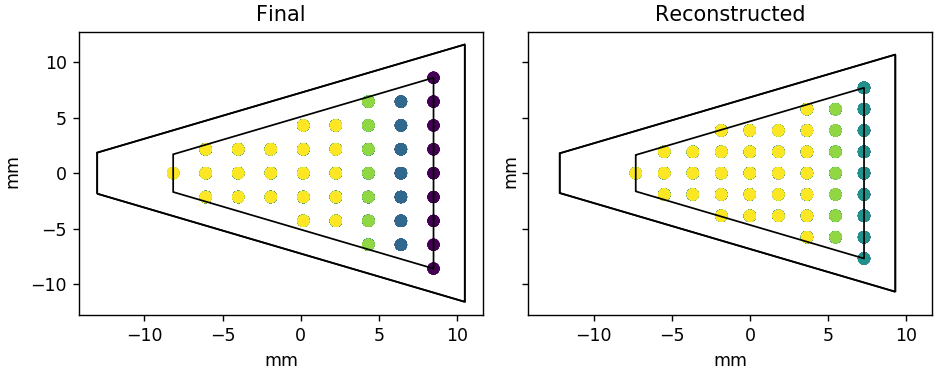

In [18]:
fig_grating, axs_grating = plt.subplots(
    ncols=2, 
    figsize=(7.5, 3), 
    constrained_layout=True,
    sharex=True,
    sharey=True,
)
_ = esis_optics_small.system.plot_footprint(
    ax=axs_grating[0],
    surf=esis_optics.components.grating.surface,
    color_axis=color_axis,
)
_ = new_esis_optics_small.system.plot_footprint(
    ax=axs_grating[1],
    surf=new_esis_optics.components.grating.surface,
    color_axis=color_axis,
)
axs_grating[0].get_legend().remove()
axs_grating[1].get_legend().remove()
_ = axs_grating[0].set_title(name_old)
_ = axs_grating[1].set_title(name_new)

## Filter

In [19]:
table_filter = pd.concat([c_old.filter.dataframe, c_new.filter.dataframe])
table_filter.index = names
table_filter

,name,piston,cylindrical radius,cylindrical azimuth,inclination,clear radius,border width
Final,filter,73.038 $\mathrm{mm}$,95.900 $\mathrm{mm}$,180.000 $\mathrm{{}^{\circ}}$,-3.450 $\mathrm{{}^{\circ}}$,15.900 $\mathrm{mm}$,0.000 $\mathrm{mm}$
Reconstructed,filter,73.038 $\mathrm{mm}$,96.255 $\mathrm{mm}$,180.000 $\mathrm{{}^{\circ}}$,-3.361 $\mathrm{{}^{\circ}}$,15.900 $\mathrm{mm}$,0.000 $\mathrm{mm}$


<IPython.core.display.Javascript object>


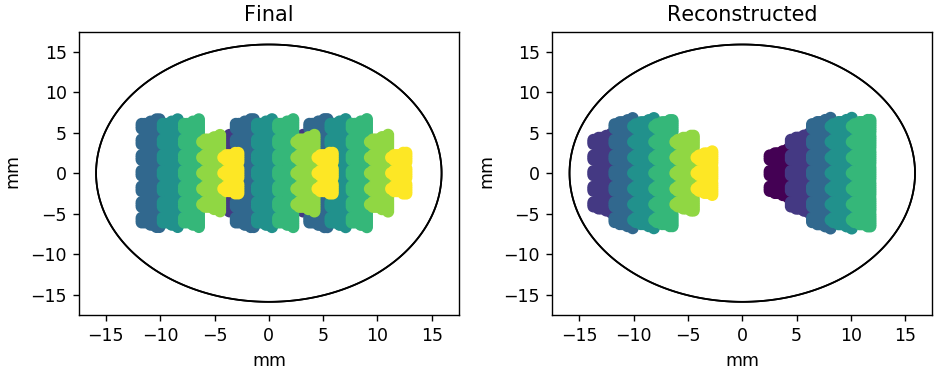

In [20]:
fig_filter, axs_filter = plt.subplots(ncols=2, figsize=(7.5, 3), constrained_layout=True)
_ = esis_optics_small.system.plot_footprint(
    ax=axs_filter[0],
    surf=esis_optics.components.filter.surface,
    color_axis=color_axis,
)
_ = new_esis_optics_small.system.plot_footprint(
    ax=axs_filter[1],
    surf=new_esis_optics.components.filter.surface,
    color_axis=color_axis,
)
axs_filter[0].get_legend().remove()
axs_filter[1].get_legend().remove()
_ = axs_filter[0].set_title(name_old)
_ = axs_filter[1].set_title(name_new)

## Detector

In [21]:
table_det = pd.concat([c_old.detector.dataframe, c_new.detector.dataframe])
table_det.index = names
table_det.T

,Final,Reconstructed
name,detector,detector
piston,-126.962 $\mathrm{mm}$,-126.962 $\mathrm{mm}$
cylindrical radius,108.000 $\mathrm{mm}$,108.000 $\mathrm{mm}$
cylindrical azimuth,180.000 $\mathrm{{}^{\circ}}$,180.000 $\mathrm{{}^{\circ}}$
inclination,-12.252 $\mathrm{{}^{\circ}}$,-8.848 $\mathrm{{}^{\circ}}$
pixel width,15.000 $\mathrm{\mu m}$,15.000 $\mathrm{\mu m}$
pixel array shape,"(2048, 1024)","(2048, 1024)"
right border width,0.000 $\mathrm{mm}$,0.000 $\mathrm{mm}$
left border width,0.000 $\mathrm{mm}$,0.000 $\mathrm{mm}$
top border width,0.000 $\mathrm{mm}$,0.000 $\mathrm{mm}$


<IPython.core.display.Javascript object>


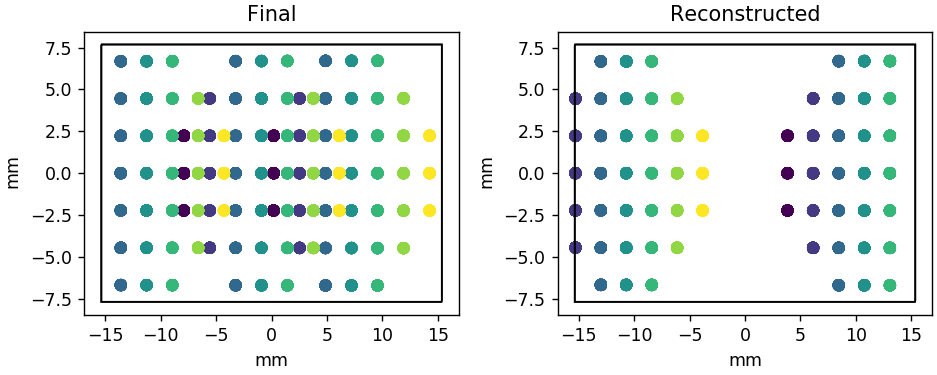

In [22]:
fig_detector, axs_detector = plt.subplots(ncols=2, figsize=(7.5, 3), constrained_layout=True)
_ = esis_optics_small.system.plot_footprint(
    ax=axs_detector[0],
    surf=esis_optics.components.detector.surface,
    color_axis=color_axis,
)
_ = new_esis_optics_small.system.plot_footprint(
    ax=axs_detector[1],
    surf=new_esis_optics.components.detector.surface,
    color_axis=color_axis,
)
axs_detector[0].get_legend().remove()
axs_detector[1].get_legend().remove()
_ = axs_detector[0].set_title(name_old)
_ = axs_detector[1].set_title(name_new)

## Spot diagrams for final ESIS design

<IPython.core.display.Javascript object>


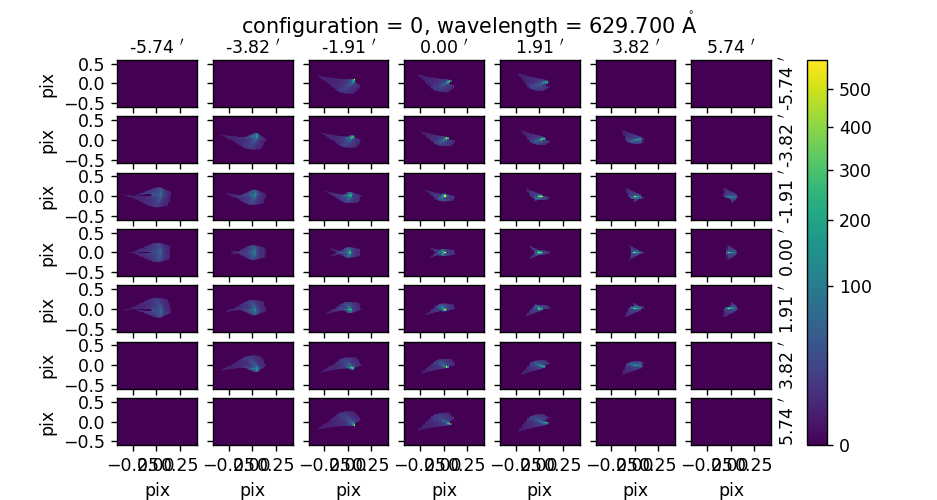

<IPython.core.display.Javascript object>


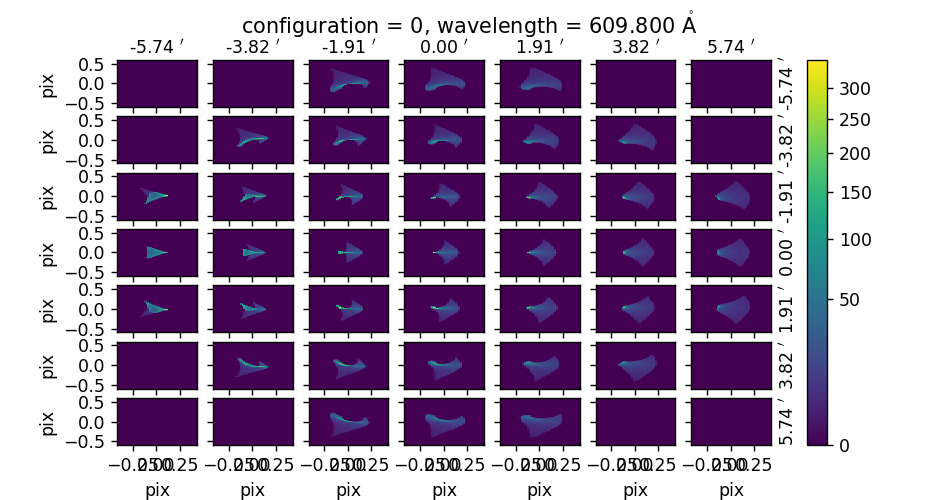

<IPython.core.display.Javascript object>


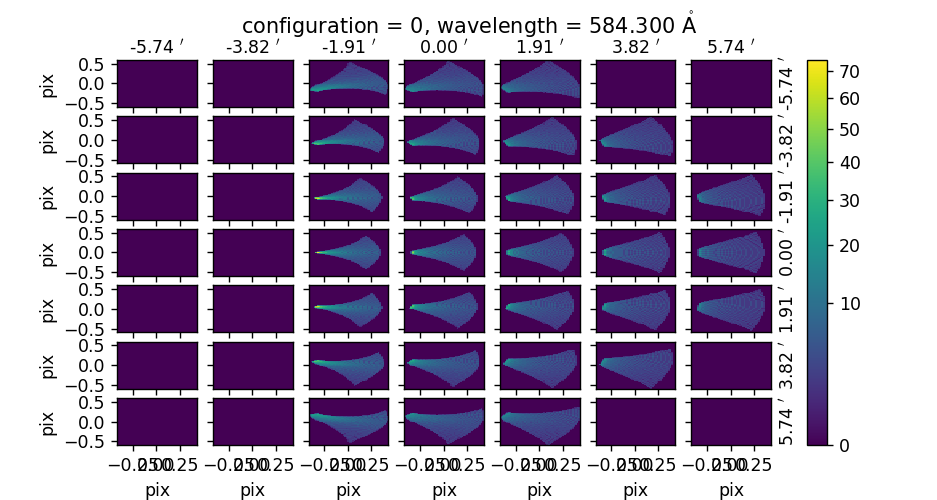

In [23]:
rays = esis_optics.system.rays_output.copy()
rays.position = (rays.position / (esis_optics.components.detector.pixel_width / u.pix)).to(u.pix)
for w in range(rays.input_grids[rays.axis.wavelength].shape[~0]):
    fig = rays.plot_pupil_hist2d_vs_field(
        wavlen_index=w,
        relative_to_centroid=(True, True),
        norm=matplotlib.colors.PowerNorm(1/2),
        bins=pupil_samples // 2,
    )
    fig.set_figheight(4)
    fig.set_figwidth(7.5)

## Spot diagrams for reconstructed ESIS design

<IPython.core.display.Javascript object>


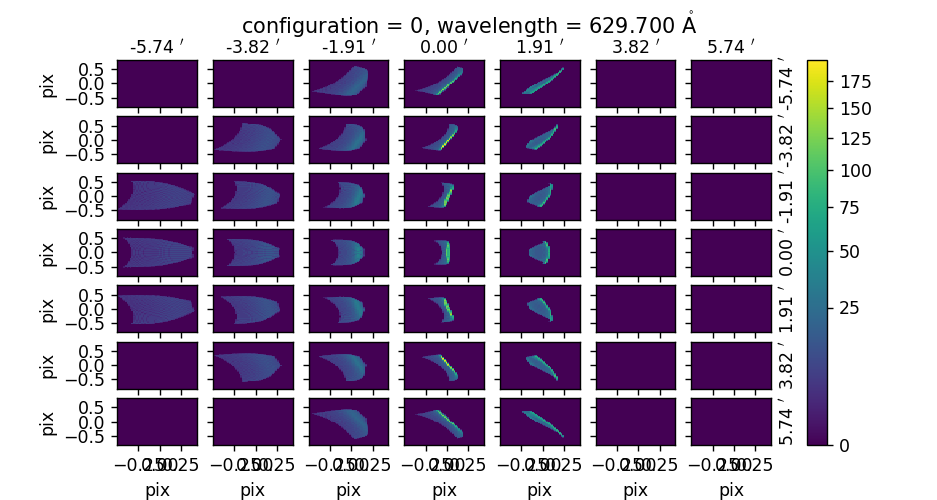

<IPython.core.display.Javascript object>


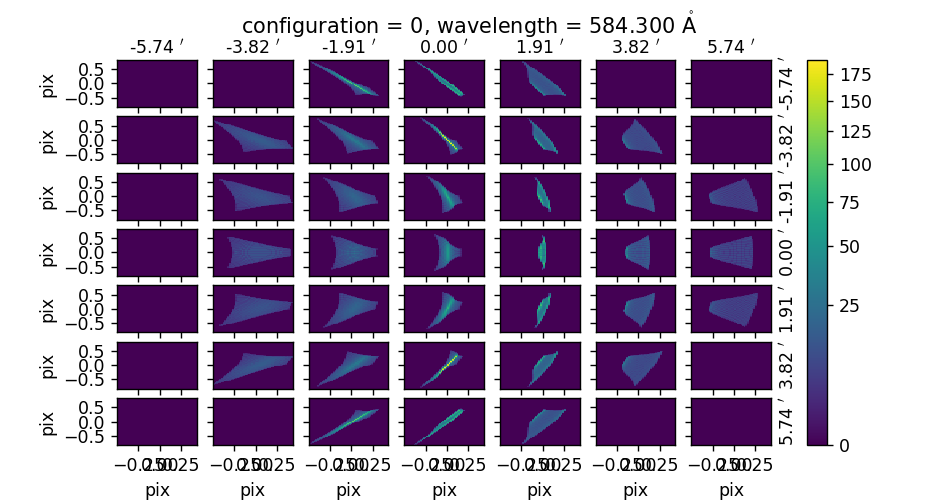

In [24]:
rays = new_esis_optics.system.rays_output.copy()
rays.position = (rays.position / (esis_optics.components.detector.pixel_width / u.pix)).to(u.pix)
for w in range(rays.input_grids[rays.axis.wavelength].shape[~0]):
    fig = rays.plot_pupil_hist2d_vs_field(
        wavlen_index=w,
        relative_to_centroid=(True, True),
        norm=matplotlib.colors.PowerNorm(1/2),
        bins=pupil_samples // 2,
    )
    fig.set_figheight(4)
    fig.set_figwidth(7.5)
